In [32]:
pip install xgboost lightgbm

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [47]:
import boto3
import pandas as pd; pd.set_option('display.max_columns', 200)
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

import time

from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, KFold

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

s3 = boto3.resource('s3')
bucket_name = 'analytics-data-science-competitions'
bucket = s3.Bucket(bucket_name)

## Defining files names
file_key_1 = 'Store-Sales-Time-Series-Forecast/oil.csv'
file_key_2 = 'Store-Sales-Time-Series-Forecast/holidays_events.csv'
file_key_3 = 'Store-Sales-Time-Series-Forecast/stores.csv'
file_key_4 = 'Store-Sales-Time-Series-Forecast/transactions.csv'
file_key_5 = 'Store-Sales-Time-Series-Forecast/train.csv'
file_key_6 = 'Store-Sales-Time-Series-Forecast/test.csv'
file_key_7 = 'Store-Sales-Time-Series-Forecast/sample_submission.csv'

bucket_object_1 = bucket.Object(file_key_1)
file_object_1 = bucket_object_1.get()
file_content_stream_1 = file_object_1.get('Body')

bucket_object_2 = bucket.Object(file_key_2)
file_object_2 = bucket_object_2.get()
file_content_stream_2 = file_object_2.get('Body')

bucket_object_3 = bucket.Object(file_key_3)
file_object_3 = bucket_object_3.get()
file_content_stream_3 = file_object_3.get('Body')

bucket_object_4 = bucket.Object(file_key_4)
file_object_4 = bucket_object_4.get()
file_content_stream_4 = file_object_4.get('Body')

bucket_object_5 = bucket.Object(file_key_5)
file_object_5 = bucket_object_5.get()
file_content_stream_5 = file_object_5.get('Body')

bucket_object_6 = bucket.Object(file_key_6)
file_object_6 = bucket_object_6.get()
file_content_stream_6 = file_object_6.get('Body')

bucket_object_7 = bucket.Object(file_key_7)
file_object_7 = bucket_object_7.get()
file_content_stream_7 = file_object_7.get('Body')

## Reading data-files
oil = pd.read_csv(file_content_stream_1)
holidays = pd.read_csv(file_content_stream_2)
stores = pd.read_csv(file_content_stream_3)
transactions = pd.read_csv(file_content_stream_4)
train = pd.read_csv(file_content_stream_5)
test = pd.read_csv(file_content_stream_6)
submission = pd.read_csv(file_content_stream_7)

## Visualizing oil prices

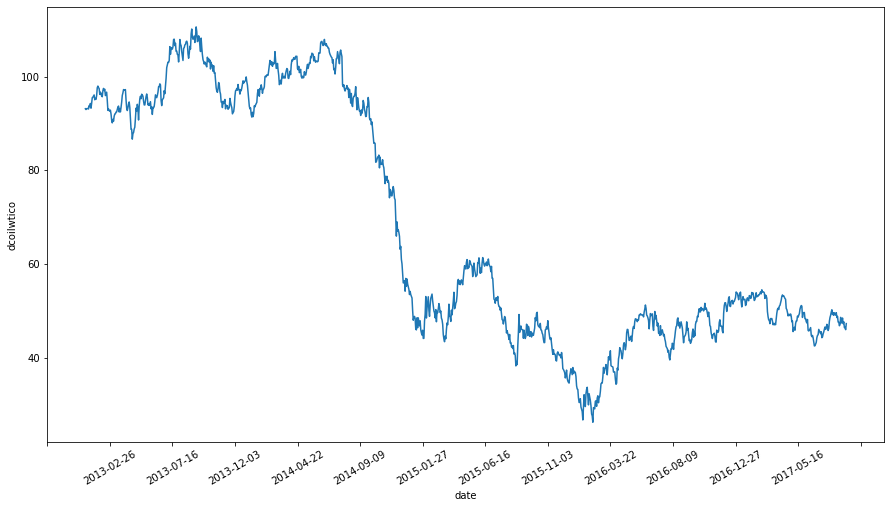

In [48]:
plt.figure(figsize = (15, 8))
ax = sns.lineplot(data = oil, x = 'date', y = 'dcoilwtico')
start, end = ax.get_xlim()
ax.set_xticks(np.arange(start, end, 100))
plt.xticks(rotation = 30);

## Holidays

In [49]:
holidays.columns = ['date', 'holiday_type', 'locale', 'locale_name', 'description', 'transferred']
holidays.head()

,date,holiday_type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [50]:
holidays['holiday_type'].value_counts()

Holiday       221
Event          56
Additional     51
Transfer       12
Bridge          5
Work Day        5
Name: holiday_type, dtype: int64

## Stores

In [51]:
stores.columns = ['store_nbr', 'city', 'state', 'store_type', 'cluster']
stores.head()

,store_nbr,city,state,store_type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [52]:
stores['store_type'].value_counts()

D    18
C    15
A     9
B     8
E     4
Name: store_type, dtype: int64

In [53]:
stores['cluster'].value_counts()

3     7
6     6
10    6
15    5
13    4
14    4
11    3
4     3
8     3
1     3
9     2
7     2
2     2
12    1
5     1
16    1
17    1
Name: cluster, dtype: int64

In [54]:
pd.crosstab(stores['cluster'], stores['store_type'])

store_type,A,B,C,D,E
cluster,,,,,
1,0,0,0,3,0
2,0,0,0,2,0
3,0,0,7,0,0
4,0,0,0,3,0
5,1,0,0,0,0
6,0,6,0,0,0
7,0,0,2,0,0
8,0,0,0,3,0
9,0,0,0,2,0


## Transactions

In [55]:
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


## Train

In [56]:
train = pd.merge(train, oil, on = 'date', how = 'left')
train = pd.merge(train, holidays, on = 'date', how = 'left')
train = pd.merge(train, stores, on = 'store_nbr', how = 'left')
train['date'] = pd.to_datetime(train['date'], format = '%Y-%m-%d')

## Basic feature engineering 
cluster_dummies = pd.get_dummies(train['cluster'])
cluster_dummies.columns = ['cluster_' + str(i) for i in range(1, 18)]
train = pd.concat([train.drop(columns = ['cluster'], axis = 1), cluster_dummies], axis = 1)

family_dummies = pd.get_dummies(train['family'])
family_dummies.columns = ['family_' + str(i) for i in range(1, 34)]
train = pd.concat([train.drop(columns = ['family'], axis = 1), family_dummies], axis = 1)

train['day'] = train['date'].dt.dayofweek
train['month'] = train['date'].dt.month
train['is_holiday'] = np.where(train['holiday_type'] == 'Holiday', 1, 0)

train.head()

,id,date,store_nbr,sales,onpromotion,dcoilwtico,holiday_type,locale,locale_name,description,transferred,city,state,store_type,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17,family_1,family_2,family_3,family_4,family_5,family_6,family_7,family_8,family_9,family_10,family_11,family_12,family_13,family_14,family_15,family_16,family_17,family_18,family_19,family_20,family_21,family_22,family_23,family_24,family_25,family_26,family_27,family_28,family_29,family_30,family_31,family_32,family_33,day,month,is_holiday
0,0,2013-01-01,1,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1
1,1,2013-01-01,1,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1
2,2,2013-01-01,1,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1
3,3,2013-01-01,1,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1
4,4,2013-01-01,1,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1


## Test

In [57]:
## Appending oil prices and holiday
test = pd.merge(test, holidays, on = 'date', how = 'left')
test = pd.merge(test, oil, on = 'date', how = 'left')
test = pd.merge(test, stores, on = 'store_nbr', how = 'left')
test['date'] = pd.to_datetime(test['date'], format = '%Y-%m-%d')

## Basic feauture engineering 
cluster_dummies = pd.get_dummies(test['cluster'])
cluster_dummies.columns = ['cluster_' + str(i) for i in range(1, 18)]
test = pd.concat([test.drop(columns = ['cluster'], axis = 1), cluster_dummies], axis = 1)

family_dummies = pd.get_dummies(test['family'])
family_dummies.columns = ['family_' + str(i) for i in range(1, 34)]
test = pd.concat([test.drop(columns = ['family'], axis = 1), family_dummies], axis = 1)

test['day'] = test['date'].dt.dayofweek
test['month'] = test['date'].dt.month
test['is_holiday'] = np.where(test['holiday_type'] == 'Holiday', 1, 0)

test.head()

,id,date,store_nbr,onpromotion,holiday_type,locale,locale_name,description,transferred,dcoilwtico,city,state,store_type,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17,family_1,family_2,family_3,family_4,family_5,family_6,family_7,family_8,family_9,family_10,family_11,family_12,family_13,family_14,family_15,family_16,family_17,family_18,family_19,family_20,family_21,family_22,family_23,family_24,family_25,family_26,family_27,family_28,family_29,family_30,family_31,family_32,family_33,day,month,is_holiday
0,3000888,2017-08-16,1,0,NaN,NaN,NaN,NaN,NaN,46.8,Quito,Pichincha,D,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,8,0
1,3000889,2017-08-16,1,0,NaN,NaN,NaN,NaN,NaN,46.8,Quito,Pichincha,D,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,8,0
2,3000890,2017-08-16,1,2,NaN,NaN,NaN,NaN,NaN,46.8,Quito,Pichincha,D,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,8,0
3,3000891,2017-08-16,1,20,NaN,NaN,NaN,NaN,NaN,46.8,Quito,Pichincha,D,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,8,0
4,3000892,2017-08-16,1,0,NaN,NaN,NaN,NaN,NaN,46.8,Quito,Pichincha,D,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,8,0


## Baseline Model LightGBM

In [58]:
X = train.drop(columns = ['id', 'date', 'store_nbr', 'sales', 'holiday_type', 'locale', 'locale_name', 'description', 'transferred', 'city', 'state', 'store_type'], axis = 1)
Y = train['sales']

test = test.drop(columns = ['id', 'date', 'store_nbr', 'holiday_type', 'locale', 'locale_name', 'description', 'transferred', 'city', 'state', 'store_type'], axis = 1)

t1 = time.time()
kf = KFold(n_splits = 5, shuffle = True, random_state = 888)
score_list_lgb = []
test_preds_lgb = []
fold = 1

for train_index, test_index in kf.split(X, Y):
    
    ## Splitting the data
    X_train , X_val = X.iloc[train_index], X.iloc[test_index]  
    Y_train, Y_val = Y.iloc[train_index], Y.iloc[test_index]    
    
    print("X_train shape is :", X_train.shape, "X_val shape is", X_val.shape)
    y_pred_list = []
    
    model_lgb = LGBMRegressor(n_estimators = 3000, 
                              learning_rate = 0.01,
                              num_leaves = 40,
                              max_depth = 9, 
                              lambda_l1 = 3, 
                              lambda_l2 = 1, 
                              bagging_fraction = 0.95, 
                              feature_fraction = 0.96)

    model = model_lgb.fit(X_train, Y_train)
    result = model_lgb.predict(X_val)
    
    result = pd.DataFrame(result)
    result.iloc[:, 0] = [0 if i <= 0 else i for i in result.iloc[:,0]]
    
    score = np.sqrt(mean_squared_log_error(Y_val, result))
    print('Fold ', str(fold), ' result is:', score, '\n')
    score_list_lgb.append(score)

    test_preds_lgb.append(model_lgb.predict(test))
    fold +=1

t2 = time.time()
print("LGBM model with cross validation take : {:.3f} sn.".format(t2-t1))

X_train shape is : (2443478, 55) X_val shape is (610870, 55)
[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] feature_fraction is set=0.96, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.96
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95
Fold  1  result is: 1.7667424200042146 

X_train shape is : (2443478, 55) X_val shape is (610870, 55)
[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] feature_fraction is set=0.96, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.96
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=1.0 wil

In [59]:
mean = sum(score_list_lgb) / len(score_list_lgb)
variance = sum([((x - mean) ** 2) for x in score_list_lgb]) / len(score_list_lgb)
res = variance ** 0.5
print("Cross validation mean score:", sum(score_list_lgb) / len(score_list_lgb))
print("Cross validation score's Standart deviation is:", res)

Cross validation mean score: 1.769960457781299
Cross validation score's Standart deviation is: 0.002857000762351154


In [60]:
test_preds_lgb = pd.DataFrame(test_preds_lgb)
print(test_preds_lgb.shape)

test_preds_lgb = test_preds_lgb.mean(axis = 0)
print(test_preds_lgb.head(5))

(5, 28512)
0       6.692441
1       6.173026
2      37.140966
3    2389.789785
4       6.182326
dtype: float64


In [63]:
submission.head()

,id,sales
0,3000888,0.0
1,3000889,0.0
2,3000890,0.0
3,3000891,0.0
4,3000892,0.0


In [64]:
submission['sales'] = test_preds_lgb
submission.to_csv('LightGBM_submission_2.csv', index = False)
submission.head()

,id,sales
0,3000888,6.692441
1,3000889,6.173026
2,3000890,37.140966
3,3000891,2389.789785
4,3000892,6.182326


## Building Baseline Model

In [16]:
pip install lightgbm xgboost

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.9/255.9 MB 2.3 MB/s eta 0:00:0000:0100:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [18]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

X = data_temp[['onpromotion', 'dcoilwtico', 'is_holiday', 'day', 'month']]
Y = data_temp['sales']

## Defining the hyper-parameter grid
XGBoost_param_grid = {'n_estimators': [300],
                      'max_depth': [5, 7],
                      'min_child_weight': [5, 7, 10],
                      'learning_rate': [0.01, 0.001],
                      'gamma': [0.3, 0.1],
                      'subsample': [0.8, 1],
                      'colsample_bytree': [0.8, 1]}

## Performing grid search with 5 folds
XGBoost_grid_search = GridSearchCV(XGBRegressor(), XGBoost_param_grid, cv = 5, scoring = 'neg_mean_squared_log_error', n_jobs = -1, verbose = 1).fit(X, Y)

## Extracting the best score
best_score = XGBoost_grid_search.best_score_
print('The best mean squared log error:', best_score)

## Extracting the best model
XGBoost_md = XGBoost_grid_search.best_estimator_

## Predicting on test with best xgboost model 
xgb_pred = XGBoost_md.predict(X_test)
xgb_pred

Fitting 5 folds for each of 96 candidates, totalling 480 fits
The best mean squared log error: -0.44573063766447885


array([3.8159997, 4.047223 , 4.172874 , 3.4401114, 1.1745007, 3.9501214,
       4.085876 , 4.1465154, 3.761886 , 4.2257566, 3.4401114, 1.1745007,
       3.9553902, 4.1356444, 4.1100802, 3.7321296], dtype=float32)

# Baseline run

In [13]:
pip install xgboost

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.9/192.9 MB 4.6 MB/s eta 0:00:0000:0100:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [33]:
import boto3
import pandas as pd; pd.set_option('display.max_columns', 200)
import numpy as np
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

s3 = boto3.resource('s3')
bucket_name = 'analytics-data-science-competitions'
bucket = s3.Bucket(bucket_name)

## Defining files names
file_key_1 = 'Store-Sales-Time-Series-Forecast/oil.csv'
file_key_2 = 'Store-Sales-Time-Series-Forecast/holidays_events.csv'
file_key_3 = 'Store-Sales-Time-Series-Forecast/stores.csv'
file_key_4 = 'Store-Sales-Time-Series-Forecast/transactions.csv'
file_key_5 = 'Store-Sales-Time-Series-Forecast/train.csv'
file_key_6 = 'Store-Sales-Time-Series-Forecast/test.csv'

bucket_object_1 = bucket.Object(file_key_1)
file_object_1 = bucket_object_1.get()
file_content_stream_1 = file_object_1.get('Body')

bucket_object_2 = bucket.Object(file_key_2)
file_object_2 = bucket_object_2.get()
file_content_stream_2 = file_object_2.get('Body')

bucket_object_3 = bucket.Object(file_key_3)
file_object_3 = bucket_object_3.get()
file_content_stream_3 = file_object_3.get('Body')

bucket_object_4 = bucket.Object(file_key_4)
file_object_4 = bucket_object_4.get()
file_content_stream_4 = file_object_4.get('Body')

bucket_object_5 = bucket.Object(file_key_5)
file_object_5 = bucket_object_5.get()
file_content_stream_5 = file_object_5.get('Body')

bucket_object_6 = bucket.Object(file_key_6)
file_object_6 = bucket_object_6.get()
file_content_stream_6 = file_object_6.get('Body')

## Reading data-files
oil = pd.read_csv(file_content_stream_1)
holidays = pd.read_csv(file_content_stream_2)
stores = pd.read_csv(file_content_stream_3)
transactions = pd.read_csv(file_content_stream_4)
train = pd.read_csv(file_content_stream_5)
test = pd.read_csv(file_content_stream_6)

## Changing feature labels in holidays and stores
holidays.columns = ['date', 'holiday_type', 'locale', 'locale_name', 'description', 'transferred']
stores.columns = ['store_nbr', 'city', 'state', 'store_type', 'cluster']

## Consolidating train data
train = pd.merge(train, oil, on = 'date', how = 'left')
train = pd.merge(train, holidays, on = 'date', how = 'left')
train = pd.merge(train, stores, on = 'store_nbr', how = 'left')
train['date'] = pd.to_datetime(train['date'], format = '%Y-%m-%d')

## Consolidating test data
test = pd.merge(test, holidays, on = 'date', how = 'left')
test = pd.merge(test, oil, on = 'date', how = 'left')
test = pd.merge(test, stores, on = 'store_nbr', how = 'left')
test['date'] = pd.to_datetime(test['date'], format = '%Y-%m-%d')

## Basic feature engineering 
train['day'] = train['date'].dt.dayofweek
train['month'] = train['date'].dt.month
train['is_holiday'] = np.where(train['holiday_type'] == 'Holiday', 1, 0)
train = train[['onpromotion', 'dcoilwtico', 'is_holiday', 'day', 'month', 'family', 'store_type', 'cluster', 'sales']]
train['cluster'] = np.where(train['cluster'] == 1, 'cluster_1',
                   np.where(train['cluster'] == 2, 'cluster_2',
                   np.where(train['cluster'] == 3, 'cluster_3',
                   np.where(train['cluster'] == 4, 'cluster_4',
                   np.where(train['cluster'] == 5, 'cluster_5',
                   np.where(train['cluster'] == 6, 'cluster_6',
                   np.where(train['cluster'] == 7, 'cluster_7',
                   np.where(train['cluster'] == 8, 'cluster_8',
                   np.where(train['cluster'] == 9, 'cluster_9',
                   np.where(train['cluster'] == 10, 'cluster_10',
                   np.where(train['cluster'] == 11, 'cluster_11',
                   np.where(train['cluster'] == 12, 'cluster_12',
                   np.where(train['cluster'] == 13, 'cluster_13',
                   np.where(train['cluster'] == 14, 'cluster_14',
                   np.where(train['cluster'] == 15, 'cluster_15',
                   np.where(train['cluster'] == 16, 'cluster_16', 'cluster_17'))))))))))))))))
train_dummies_1 = pd.get_dummies(train['family'])
train_dummies_2 = pd.get_dummies(train['store_type'])
train_dummies_3 = pd.get_dummies(train['cluster'])
train = pd.concat([train.drop(columns = ['family', 'store_type', 'cluster'], axis = 1), train_dummies_1, train_dummies_2, train_dummies_3], axis = 1)

test['day'] = test['date'].dt.dayofweek
test['month'] = test['date'].dt.month
test['is_holiday'] = np.where(test['holiday_type'] == 'Holiday', 1, 0)
test = test[['onpromotion', 'dcoilwtico', 'is_holiday', 'day', 'month', 'family', 'store_type', 'cluster']]
test['cluster'] = np.where(test['cluster'] == 1, 'cluster_1',
                  np.where(test['cluster'] == 2, 'cluster_2',
                  np.where(test['cluster'] == 3, 'cluster_3',
                  np.where(test['cluster'] == 4, 'cluster_4',
                  np.where(test['cluster'] == 5, 'cluster_5',
                  np.where(test['cluster'] == 6, 'cluster_6',
                  np.where(test['cluster'] == 7, 'cluster_7',
                  np.where(test['cluster'] == 8, 'cluster_8',
                  np.where(test['cluster'] == 9, 'cluster_9',
                  np.where(test['cluster'] == 10, 'cluster_10',
                  np.where(test['cluster'] == 11, 'cluster_11',
                  np.where(test['cluster'] == 12, 'cluster_12',
                  np.where(test['cluster'] == 13, 'cluster_13',
                  np.where(test['cluster'] == 14, 'cluster_14',
                  np.where(test['cluster'] == 15, 'cluster_15',
                  np.where(test['cluster'] == 16, 'cluster_16', 'cluster_17'))))))))))))))))                            
test_dummies_1 = pd.get_dummies(test['family'])
test_dummies_2 = pd.get_dummies(test['store_type'])
test_dummies_3 = pd.get_dummies(test['cluster'])
test = pd.concat([test.drop(columns = ['family', 'store_type', 'cluster'], axis = 1), test_dummies_1, test_dummies_2, test_dummies_3], axis = 1)

In [35]:
train.head()

,onpromotion,dcoilwtico,is_holiday,day,month,sales,AUTOMOTIVE,BABY CARE,BEAUTY,BEVERAGES,BOOKS,BREAD/BAKERY,CELEBRATION,CLEANING,DAIRY,DELI,EGGS,FROZEN FOODS,GROCERY I,GROCERY II,HARDWARE,HOME AND KITCHEN I,HOME AND KITCHEN II,HOME APPLIANCES,HOME CARE,LADIESWEAR,LAWN AND GARDEN,LINGERIE,"LIQUOR,WINE,BEER",MAGAZINES,MEATS,PERSONAL CARE,PET SUPPLIES,PLAYERS AND ELECTRONICS,POULTRY,PREPARED FOODS,PRODUCE,SCHOOL AND OFFICE SUPPLIES,SEAFOOD,A,B,C,D,E,cluster_1,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9
0,0,NaN,1,1,1,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,0,NaN,1,1,1,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,NaN,1,1,1,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,0,NaN,1,1,1,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0,NaN,1,1,1,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [36]:
test.head()

,onpromotion,dcoilwtico,is_holiday,day,month,AUTOMOTIVE,BABY CARE,BEAUTY,BEVERAGES,BOOKS,BREAD/BAKERY,CELEBRATION,CLEANING,DAIRY,DELI,EGGS,FROZEN FOODS,GROCERY I,GROCERY II,HARDWARE,HOME AND KITCHEN I,HOME AND KITCHEN II,HOME APPLIANCES,HOME CARE,LADIESWEAR,LAWN AND GARDEN,LINGERIE,"LIQUOR,WINE,BEER",MAGAZINES,MEATS,PERSONAL CARE,PET SUPPLIES,PLAYERS AND ELECTRONICS,POULTRY,PREPARED FOODS,PRODUCE,SCHOOL AND OFFICE SUPPLIES,SEAFOOD,A,B,C,D,E,cluster_1,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9
0,0,46.8,0,2,8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,0,46.8,0,2,8,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,2,46.8,0,2,8,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,20,46.8,0,2,8,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0,46.8,0,2,8,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [20]:
X = train.drop(columns = ['sales'], axis = 1)
Y = train['sales']

## Defining the hyper-parameter grid
XGBoost_param_grid = {'n_estimators': [300],
                      'max_depth': [5, 7],
                      'min_child_weight': [5, 7, 10],
                      'learning_rate': [0.01, 0.001],
                      'gamma': [0.3, 0.1],
                      'subsample': [0.8, 1],
                      'colsample_bytree': [0.8, 1]}

## Performing grid search with 5 folds
XGBoost_grid_search = GridSearchCV(XGBRegressor(), XGBoost_param_grid, cv = 5, scoring = 'neg_mean_squared_log_error', n_jobs = -1, verbose = 4).fit(X, Y)

## Extracting the best score
best_score = XGBoost_grid_search.best_score_
print('The best mean squared log error:', best_score)

## Extracting the best model
XGBoost_md = XGBoost_grid_search.best_estimator_

## Predicting on test with best xgboost model 
xgb_pred = XGBoost_md.predict(X_test)
xgb_pred

Fitting 5 folds for each of 96 candidates, totalling 480 fits


KeyboardInterrupt: 

In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv('LightGBM_submission_md1.csv')
data.head()

,id,sales
0,3000888,9.166116
1,3000889,8.590923
2,3000890,36.543278
3,3000891,2445.364875
4,3000892,8.611931


In [3]:
data['sales'] = np.where(data['sales'] < 0, 0.0, data['sales'])
data.to_csv('LightGBM_submission_md1_1.csv', index = False)

In [3]:
import pandas as pd 
import numpy as np

data1 = pd.read_csv('LightGBM_submission_md1_30.csv')
data1.columns = ['id', 'sales_1']

data2 = pd.read_csv('Cluster_17.csv')
data2.columns = ['id', 'sales_2']

data = pd.merge(data1, data2, on = 'id', how = 'left')
data['sales'] = np.where(np.isnan(data['sales_2']), data['sales_1'], data['sales_2'])
data = data.drop(columns = ['sales_1', 'sales_2'], axis = 1)
data.head()

,id,sales
0,3000888,9.967121
1,3000889,5.584560
2,3000890,19.382899
3,3000891,2531.425710
4,3000892,5.684833


In [4]:
data.to_csv('LightGBM_submission_md1_31.csv', index = False)

# Cluster 1

In [24]:
import boto3
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

import matplotlib.pyplot as plt
import time

from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, KFold, GroupKFold

# from lightgbm import LGBMRegressor

s3 = boto3.resource('s3')
bucket_name = 'analytics-data-science-competitions'
bucket = s3.Bucket(bucket_name)

## Defining files names
file_key_1 = 'Store-Sales-Time-Series-Forecast/oil.csv'
file_key_2 = 'Store-Sales-Time-Series-Forecast/holidays_events.csv'
file_key_3 = 'Store-Sales-Time-Series-Forecast/stores.csv'
file_key_4 = 'Store-Sales-Time-Series-Forecast/transactions.csv'
file_key_5 = 'Store-Sales-Time-Series-Forecast/train.csv'
file_key_6 = 'Store-Sales-Time-Series-Forecast/test.csv'
file_key_7 = 'Store-Sales-Time-Series-Forecast/sample_submission.csv'

bucket_object_1 = bucket.Object(file_key_1)
file_object_1 = bucket_object_1.get()
file_content_stream_1 = file_object_1.get('Body')

bucket_object_2 = bucket.Object(file_key_2)
file_object_2 = bucket_object_2.get()
file_content_stream_2 = file_object_2.get('Body')

bucket_object_3 = bucket.Object(file_key_3)
file_object_3 = bucket_object_3.get()
file_content_stream_3 = file_object_3.get('Body')

bucket_object_4 = bucket.Object(file_key_4)
file_object_4 = bucket_object_4.get()
file_content_stream_4 = file_object_4.get('Body')

bucket_object_5 = bucket.Object(file_key_5)
file_object_5 = bucket_object_5.get()
file_content_stream_5 = file_object_5.get('Body')

bucket_object_6 = bucket.Object(file_key_6)
file_object_6 = bucket_object_6.get()
file_content_stream_6 = file_object_6.get('Body')

bucket_object_7 = bucket.Object(file_key_7)
file_object_7 = bucket_object_7.get()
file_content_stream_7 = file_object_7.get('Body')

## Reading data-files
oil = pd.read_csv(file_content_stream_1)
holidays = pd.read_csv(file_content_stream_2)
stores = pd.read_csv(file_content_stream_3)
transactions = pd.read_csv(file_content_stream_4)
train = pd.read_csv(file_content_stream_5)
test = pd.read_csv(file_content_stream_6)
submission = pd.read_csv(file_content_stream_7)

## Updating holiday column names
holidays.columns = ['date', 'holiday_type', 'locale', 'locale_name', 'description', 'transferred']

## Updating store column names
stores.columns = ['store_nbr', 'city', 'state', 'store_type', 'cluster']

###################
## Train Dataset ##
###################

train = pd.merge(train, oil, on = 'date', how = 'left')
train = pd.merge(train, holidays, on = 'date', how = 'left')
train = pd.merge(train, stores, on = 'store_nbr', how = 'left')
train['date'] = pd.to_datetime(train['date'], format = '%Y-%m-%d')

## Basic feature engineering 
cluster_dummies = pd.get_dummies(train['cluster'])
cluster_dummies.columns = ['cluster_' + str(i) for i in range(1, 18)]
train = pd.concat([train.drop(columns = ['cluster'], axis = 1), cluster_dummies], axis = 1)

family_dummies = pd.get_dummies(train['family'])
family_dummies.columns = ['family_' + str(i) for i in range(1, 34)]
train = pd.concat([train.drop(columns = ['family'], axis = 1), family_dummies], axis = 1)

train['day'] = train['date'].dt.dayofweek
train['month'] = train['date'].dt.month
train['year'] = train['date'].dt.year
train['is_holiday'] = np.where(train['holiday_type'] == 'Holiday', 1, 0)

transactions['date'] = pd.to_datetime(transactions['date'], format = '%Y-%m-%d')
train = pd.merge(train, transactions, on = ['date', 'store_nbr'], how = 'left')
train['transactions'] = train['transactions'].fillna(0)


##################
## Test Dataset ##
##################

## Aggregating transactions
trans_agg = pd.DataFrame(train.groupby(['store_nbr', 'month', 'day'])['transactions'].mean())
trans_agg['store_nbr'] = trans_agg.index.get_level_values(0)
trans_agg['month'] = trans_agg.index.get_level_values(1)
trans_agg['day'] = trans_agg.index.get_level_values(2)
trans_agg = trans_agg.reset_index(drop = True)
trans_agg = trans_agg[['store_nbr', 'month', 'day', 'transactions']]

## Appending oil prices and holiday
test = pd.merge(test, oil, on = 'date', how = 'left')
test = pd.merge(test, holidays, on = 'date', how = 'left')
test = pd.merge(test, stores, on = 'store_nbr', how = 'left')
test['date'] = pd.to_datetime(test['date'], format = '%Y-%m-%d')

## Basic feauture engineering 
cluster_dummies = pd.get_dummies(test['cluster'])
cluster_dummies.columns = ['cluster_' + str(i) for i in range(1, 18)]
test = pd.concat([test.drop(columns = ['cluster'], axis = 1), cluster_dummies], axis = 1)

family_dummies = pd.get_dummies(test['family'])
family_dummies.columns = ['family_' + str(i) for i in range(1, 34)]
test = pd.concat([test.drop(columns = ['family'], axis = 1), family_dummies], axis = 1)

test['day'] = test['date'].dt.dayofweek
test['month'] = test['date'].dt.month
test['year'] = test['date'].dt.year
test['is_holiday'] = np.where(test['holiday_type'] == 'Holiday', 1, 0)

test = pd.merge(test, trans_agg, on = ['store_nbr', 'month', 'day'], how = 'left')


###############
## Cluster 1 ##
###############

train = train[train['cluster_2'] == 1].reset_index(drop = True)
test = test[test['cluster_2'] == 1].reset_index(drop = True)

In [38]:
trans_agg[(trans_agg['store_nbr'] == 42) & (trans_agg['month'] == 8)]

,store_nbr,month,day,transactions
3493,42,8,0,470.050000
3494,42,8,1,453.850000
3495,42,8,2,440.421053
3496,42,8,3,373.578947
3497,42,8,4,470.200000
3498,42,8,5,493.428571
3499,42,8,6,483.050000


In [25]:
train.head()

,id,date,store_nbr,sales,onpromotion,dcoilwtico,holiday_type,locale,locale_name,description,transferred,city,state,store_type,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17,family_1,family_2,family_3,family_4,family_5,family_6,family_7,family_8,family_9,family_10,family_11,family_12,family_13,family_14,family_15,family_16,family_17,family_18,family_19,family_20,family_21,family_22,family_23,family_24,family_25,family_26,family_27,family_28,family_29,family_30,family_31,family_32,family_33,day,month,year,is_holiday,transactions
0,990,2013-01-01,37,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,Cuenca,Azuay,D,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2013,1,0.0
1,991,2013-01-01,37,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,Cuenca,Azuay,D,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2013,1,0.0
2,992,2013-01-01,37,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,Cuenca,Azuay,D,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2013,1,0.0
3,993,2013-01-01,37,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,Cuenca,Azuay,D,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2013,1,0.0
4,994,2013-01-01,37,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,Cuenca,Azuay,D,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2013,1,0.0


In [26]:
train.groupby('date')['sales'].sum()

date
2013-01-01        0.000000
2013-01-02    11111.838999
2013-01-03     9335.661000
2013-01-04     8954.490010
2013-01-05    11268.065000
                  ...     
2017-08-11    20019.100004
2017-08-12    18452.548990
2017-08-13    16867.120000
2017-08-14    23754.288999
2017-08-15    20785.324986
Name: sales, Length: 1684, dtype: float64

In [27]:
test.head()

,id,date,store_nbr,onpromotion,dcoilwtico,holiday_type,locale,locale_name,description,transferred,city,state,store_type,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17,family_1,family_2,family_3,family_4,family_5,family_6,family_7,family_8,family_9,family_10,family_11,family_12,family_13,family_14,family_15,family_16,family_17,family_18,family_19,family_20,family_21,family_22,family_23,family_24,family_25,family_26,family_27,family_28,family_29,family_30,family_31,family_32,family_33,day,month,year,is_holiday,transactions
0,3001878,2017-08-16,37,0,46.8,NaN,NaN,NaN,NaN,NaN,Cuenca,Azuay,D,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,8,2017,0,1491.263158
1,3001879,2017-08-16,37,0,46.8,NaN,NaN,NaN,NaN,NaN,Cuenca,Azuay,D,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,8,2017,0,1491.263158
2,3001880,2017-08-16,37,2,46.8,NaN,NaN,NaN,NaN,NaN,Cuenca,Azuay,D,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,8,2017,0,1491.263158
3,3001881,2017-08-16,37,26,46.8,NaN,NaN,NaN,NaN,NaN,Cuenca,Azuay,D,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,8,2017,0,1491.263158
4,3001882,2017-08-16,37,0,46.8,NaN,NaN,NaN,NaN,NaN,Cuenca,Azuay,D,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,8,2017,0,1491.263158


In [28]:
train['store_nbr'].value_counts()

37    56562
42    56562
Name: store_nbr, dtype: int64

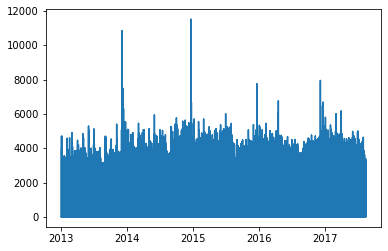

In [29]:
plt.plot('date', 'sales', data = train[train['store_nbr'] == 37])
plt.show()

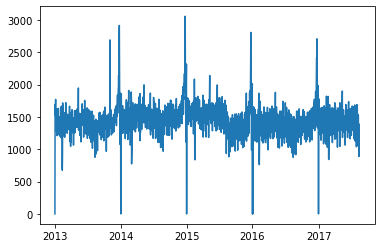

In [30]:
plt.plot('date', 'transactions', data = train[train['store_nbr'] == 37])
plt.show()

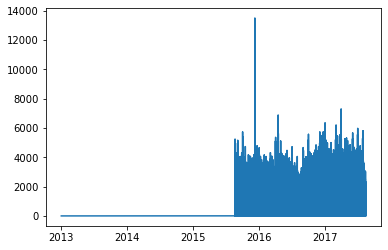

In [31]:
plt.plot('date', 'sales', data = train[train['store_nbr'] == 42])
plt.show()

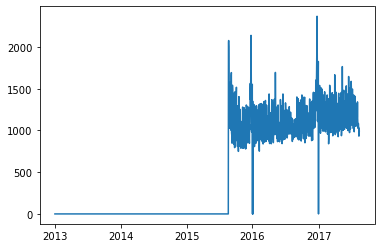

In [32]:
plt.plot('date', 'transactions', data = train[train['store_nbr'] == 42])
plt.show()

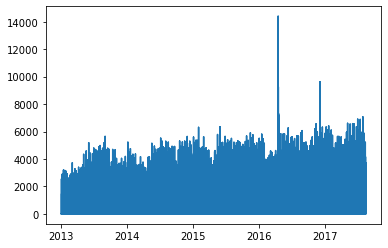

In [17]:
plt.plot('date', 'sales', data = train[train['store_nbr'] == 27])
plt.show()

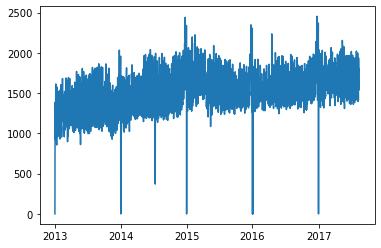

In [22]:
plt.plot('date', 'transactions', data = train[train['store_nbr'] == 27])
plt.show()

In [4]:
train['store_nbr'].value_counts()

24    56562
25    56562
27    56562
Name: store_nbr, dtype: int64

In [39]:
test.head()

,id,date,store_nbr,onpromotion,dcoilwtico,holiday_type,locale,locale_name,description,transferred,city,state,store_type,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17,family_1,family_2,family_3,family_4,family_5,family_6,family_7,family_8,family_9,family_10,family_11,family_12,family_13,family_14,family_15,family_16,family_17,family_18,family_19,family_20,family_21,family_22,family_23,family_24,family_25,family_26,family_27,family_28,family_29,family_30,family_31,family_32,family_33,day,month,year,is_holiday,transactions
0,3001416,2017-08-16,24,0,46.8,NaN,NaN,NaN,NaN,NaN,Guayaquil,Guayas,D,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,8,2017,0,2410.210526
1,3001417,2017-08-16,24,0,46.8,NaN,NaN,NaN,NaN,NaN,Guayaquil,Guayas,D,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,8,2017,0,2410.210526
2,3001418,2017-08-16,24,2,46.8,NaN,NaN,NaN,NaN,NaN,Guayaquil,Guayas,D,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,8,2017,0,2410.210526
3,3001419,2017-08-16,24,24,46.8,NaN,NaN,NaN,NaN,NaN,Guayaquil,Guayas,D,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,8,2017,0,2410.210526
4,3001420,2017-08-16,24,0,46.8,NaN,NaN,NaN,NaN,NaN,Guayaquil,Guayas,D,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,8,2017,0,2410.210526


In [5]:
transactions['date'] = pd.to_datetime(transactions['date'])
transactions[(transactions['store_nbr'] == 24) & (transactions['date'] >= pd.to_datetime('2014-04-15'))]

,date,store_nbr,transactions
26424,2014-07-24,24,2191
26472,2014-07-25,24,1816
26520,2014-07-26,24,2078
26568,2014-07-27,24,1718
26616,2014-07-28,24,2237
...,...,...,...
83241,2017-08-11,24,2008
83295,2017-08-12,24,1943
83349,2017-08-13,24,1520
83403,2017-08-14,24,2092


In [6]:
train.head()

,id,date,store_nbr,sales,onpromotion,dcoilwtico,holiday_type,locale,locale_name,description,transferred,city,state,store_type,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17,family_1,family_2,family_3,family_4,family_5,family_6,family_7,family_8,family_9,family_10,family_11,family_12,family_13,family_14,family_15,family_16,family_17,family_18,family_19,family_20,family_21,family_22,family_23,family_24,family_25,family_26,family_27,family_28,family_29,family_30,family_31,family_32,family_33,day,month,year,is_holiday,transactions
0,528,2013-01-01,24,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,Guayaquil,Guayas,D,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2013,1,0.0
1,529,2013-01-01,24,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,Guayaquil,Guayas,D,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2013,1,0.0
2,530,2013-01-01,24,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,Guayaquil,Guayas,D,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2013,1,0.0
3,531,2013-01-01,24,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,Guayaquil,Guayas,D,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2013,1,0.0
4,532,2013-01-01,24,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,Guayaquil,Guayas,D,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2013,1,0.0


In [7]:
transactions['date'] = pd.to_datetime(transactions['date'])
train = pd.merge(train, transactions, on = ['date', 'store_nbr'], how = 'left')

In [9]:
train.head()

,id,date,store_nbr,sales,onpromotion,dcoilwtico,holiday_type,locale,locale_name,description,transferred,city,state,store_type,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17,family_1,family_2,family_3,family_4,family_5,family_6,family_7,family_8,family_9,family_10,family_11,family_12,family_13,family_14,family_15,family_16,family_17,family_18,family_19,family_20,family_21,family_22,family_23,family_24,family_25,family_26,family_27,family_28,family_29,family_30,family_31,family_32,family_33,day,month,year,is_holiday,transactions_x,transactions_y
0,528,2013-01-01,24,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,Guayaquil,Guayas,D,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2013,1,0.0,NaN
1,529,2013-01-01,24,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,Guayaquil,Guayas,D,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2013,1,0.0,NaN
2,530,2013-01-01,24,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,Guayaquil,Guayas,D,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2013,1,0.0,NaN
3,531,2013-01-01,24,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,Guayaquil,Guayas,D,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2013,1,0.0,NaN
4,532,2013-01-01,24,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,Guayaquil,Guayas,D,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2013,1,0.0,NaN


In [8]:
train['transactions'] = train['transactions'].fillna(0)

KeyError: 'transactions'

In [7]:
train.head()

,id,date,store_nbr,sales,onpromotion,dcoilwtico,holiday_type,locale,locale_name,description,...,family_29,family_30,family_31,family_32,family_33,day,month,year,is_holiday,transactions
0,528,2013-01-01,24,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,...,0,0,0,0,0,1,1,2013,1,0.0
1,529,2013-01-01,24,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,...,0,0,0,0,0,1,1,2013,1,0.0
2,530,2013-01-01,24,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,...,0,0,0,0,0,1,1,2013,1,0.0
3,531,2013-01-01,24,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,...,0,0,0,0,0,1,1,2013,1,0.0
4,532,2013-01-01,24,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,...,0,0,0,0,0,1,1,2013,1,0.0


In [10]:
train.columns

Index(['id', 'date', 'store_nbr', 'sales', 'onpromotion', 'dcoilwtico',
       'holiday_type', 'locale', 'locale_name', 'description', 'transferred',
       'city', 'state', 'store_type', 'cluster_1', 'cluster_2', 'cluster_3',
       'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7', 'cluster_8',
       'cluster_9', 'cluster_10', 'cluster_11', 'cluster_12', 'cluster_13',
       'cluster_14', 'cluster_15', 'cluster_16', 'cluster_17', 'family_1',
       'family_2', 'family_3', 'family_4', 'family_5', 'family_6', 'family_7',
       'family_8', 'family_9', 'family_10', 'family_11', 'family_12',
       'family_13', 'family_14', 'family_15', 'family_16', 'family_17',
       'family_18', 'family_19', 'family_20', 'family_21', 'family_22',
       'family_23', 'family_24', 'family_25', 'family_26', 'family_27',
       'family_28', 'family_29', 'family_30', 'family_31', 'family_32',
       'family_33', 'day', 'month', 'year', 'is_holiday', 'transactions'],
      dtype='object')

In [13]:
train[['sales', 'transactions']].describe()

,sales,transactions
count,169686.000000,169686.000000
mean,327.022808,1499.774796
std,827.669743,693.389018
min,0.000000,0.000000
25%,0.000000,918.000000
50%,15.000000,1458.500000
75%,225.000000,2079.000000
max,35828.000000,4353.000000


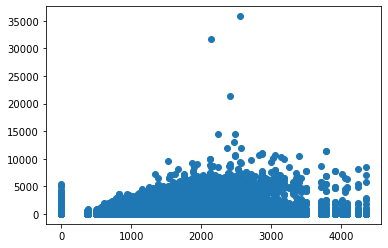

In [15]:
import matplotlib.pyplot as plt

plt.plot('transactions', 'sales', 'o', data = train)
plt.show();

In [16]:
test

,id,date,store_nbr,onpromotion,holiday_type,locale,locale_name,description,transferred,dcoilwtico,...,family_28,family_29,family_30,family_31,family_32,family_33,day,month,year,is_holiday
0,3001416,2017-08-16,24,0,NaN,NaN,NaN,NaN,NaN,46.80,...,0,0,0,0,0,0,2,8,2017,0
1,3001417,2017-08-16,24,0,NaN,NaN,NaN,NaN,NaN,46.80,...,0,0,0,0,0,0,2,8,2017,0
2,3001418,2017-08-16,24,2,NaN,NaN,NaN,NaN,NaN,46.80,...,0,0,0,0,0,0,2,8,2017,0
3,3001419,2017-08-16,24,24,NaN,NaN,NaN,NaN,NaN,46.80,...,0,0,0,0,0,0,2,8,2017,0
4,3001420,2017-08-16,24,0,NaN,NaN,NaN,NaN,NaN,46.80,...,0,0,0,0,0,0,2,8,2017,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1579,3028273,2017-08-31,27,0,NaN,NaN,NaN,NaN,NaN,47.26,...,0,1,0,0,0,0,3,8,2017,0
1580,3028274,2017-08-31,27,0,NaN,NaN,NaN,NaN,NaN,47.26,...,0,0,1,0,0,0,3,8,2017,0
1581,3028275,2017-08-31,27,2,NaN,NaN,NaN,NaN,NaN,47.26,...,0,0,0,1,0,0,3,8,2017,0
1582,3028276,2017-08-31,27,0,NaN,NaN,NaN,NaN,NaN,47.26,...,0,0,0,0,1,0,3,8,2017,0


In [18]:
train.head()

,id,date,store_nbr,sales,onpromotion,dcoilwtico,holiday_type,locale,locale_name,description,...,family_29,family_30,family_31,family_32,family_33,day,month,year,is_holiday,transactions
0,528,2013-01-01,24,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,...,0,0,0,0,0,1,1,2013,1,0.0
1,529,2013-01-01,24,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,...,0,0,0,0,0,1,1,2013,1,0.0
2,530,2013-01-01,24,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,...,0,0,0,0,0,1,1,2013,1,0.0
3,531,2013-01-01,24,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,...,0,0,0,0,0,1,1,2013,1,0.0
4,532,2013-01-01,24,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,...,0,0,0,0,0,1,1,2013,1,0.0


In [22]:
trans_agg = pd.DataFrame(train.groupby(['store_nbr', 'month', 'day'])['transactions'].mean())
trans_agg['store_nbr'] = trans_agg.index.get_level_values(0)
trans_agg['month'] = trans_agg.index.get_level_values(1)
trans_agg['day'] = trans_agg.index.get_level_values(2)
trans_agg = trans_agg.reset_index(drop = True)
trans_agg = trans_agg[['store_nbr', 'month', 'day', 'transactions']]
trans_agg.head()

,store_nbr,month,day,transactions
0,24,1,0,2254.571429
1,24,1,1,2141.045455
2,24,1,2,2328.818182
3,24,1,3,2143.739130
4,24,1,4,2346.478261


In [23]:
test_new = pd.merge(test, trans_agg, on = ['store_nbr', 'month', 'day'], how = 'left')
test_new.head(10)

,id,date,store_nbr,onpromotion,holiday_type,locale,locale_name,description,transferred,dcoilwtico,...,family_29,family_30,family_31,family_32,family_33,day,month,year,is_holiday,transactions
0,3001416,2017-08-16,24,0,NaN,NaN,NaN,NaN,NaN,46.8,...,0,0,0,0,0,2,8,2017,0,2410.210526
1,3001417,2017-08-16,24,0,NaN,NaN,NaN,NaN,NaN,46.8,...,0,0,0,0,0,2,8,2017,0,2410.210526
2,3001418,2017-08-16,24,2,NaN,NaN,NaN,NaN,NaN,46.8,...,0,0,0,0,0,2,8,2017,0,2410.210526
3,3001419,2017-08-16,24,24,NaN,NaN,NaN,NaN,NaN,46.8,...,0,0,0,0,0,2,8,2017,0,2410.210526
4,3001420,2017-08-16,24,0,NaN,NaN,NaN,NaN,NaN,46.8,...,0,0,0,0,0,2,8,2017,0,2410.210526
5,3001421,2017-08-16,24,12,NaN,NaN,NaN,NaN,NaN,46.8,...,0,0,0,0,0,2,8,2017,0,2410.210526
6,3001422,2017-08-16,24,0,NaN,NaN,NaN,NaN,NaN,46.8,...,0,0,0,0,0,2,8,2017,0,2410.210526
7,3001423,2017-08-16,24,23,NaN,NaN,NaN,NaN,NaN,46.8,...,0,0,0,0,0,2,8,2017,0,2410.210526
8,3001424,2017-08-16,24,41,NaN,NaN,NaN,NaN,NaN,46.8,...,0,0,0,0,0,2,8,2017,0,2410.210526
9,3001425,2017-08-16,24,18,NaN,NaN,NaN,NaN,NaN,46.8,...,0,0,0,0,0,2,8,2017,0,2410.210526


In [7]:
train.columns

Index(['id', 'date', 'store_nbr', 'sales', 'onpromotion', 'dcoilwtico',
       'holiday_type', 'locale', 'locale_name', 'description', 'transferred',
       'city', 'state', 'store_type', 'cluster_1', 'cluster_2', 'cluster_3',
       'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7', 'cluster_8',
       'cluster_9', 'cluster_10', 'cluster_11', 'cluster_12', 'cluster_13',
       'cluster_14', 'cluster_15', 'cluster_16', 'cluster_17', 'family_1',
       'family_2', 'family_3', 'family_4', 'family_5', 'family_6', 'family_7',
       'family_8', 'family_9', 'family_10', 'family_11', 'family_12',
       'family_13', 'family_14', 'family_15', 'family_16', 'family_17',
       'family_18', 'family_19', 'family_20', 'family_21', 'family_22',
       'family_23', 'family_24', 'family_25', 'family_26', 'family_27',
       'family_28', 'family_29', 'family_30', 'family_31', 'family_32',
       'family_33', 'day', 'month', 'year', 'is_holiday'],
      dtype='object')

In [8]:
train['store_type'].value_counts()

D    169686
Name: store_type, dtype: int64

In [9]:
train['store_nbr'].value_counts()

24    56562
25    56562
27    56562
Name: store_nbr, dtype: int64

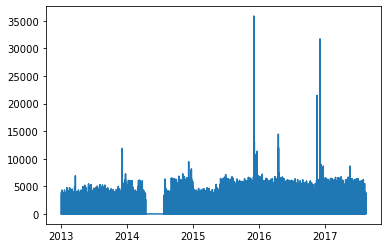

In [10]:
import matplotlib.pyplot as plt

plt.plot('date', 'sales', data = train[train['store_nbr'] == 24])
plt.show();

In [17]:
train[(train['store_nbr'] == 24) & (train['sales'] == 0) & (train['year'] == 2014) & (train['month'] == 6)].describe()

,id,store_nbr,sales,onpromotion,dcoilwtico,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,...,family_28,family_29,family_30,family_31,family_32,family_33,day,month,year,is_holiday
count,1089.000000,1089.0,1089.0,1089.0,792.000000,1089.0,1089.0,1089.0,1089.0,1089.0,...,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.0,1089.0,1089.000000
mean,945652.000000,24.0,0.0,0.0,105.950000,1.0,0.0,0.0,0.0,0.0,...,0.030303,0.030303,0.030303,0.030303,0.030303,0.030303,2.909091,6.0,2014.0,0.121212
std,15497.686281,0.0,0.0,0.0,1.570065,0.0,0.0,0.0,0.0,0.0,...,0.171499,0.171499,0.171499,0.171499,0.171499,0.171499,2.006424,0.0,0.0,0.326524
min,918258.000000,24.0,0.0,0.0,103.070000,1.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.0,2014.0,0.000000
25%,932522.000000,24.0,0.0,0.0,105.035000,1.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.0,2014.0,0.000000
50%,946786.000000,24.0,0.0,0.0,106.640000,1.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,6.0,2014.0,0.000000
75%,961032.000000,24.0,0.0,0.0,107.040000,1.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,6.0,2014.0,0.000000
max,969968.000000,24.0,0.0,0.0,107.950000,1.0,0.0,0.0,0.0,0.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,6.0,2014.0,1.000000


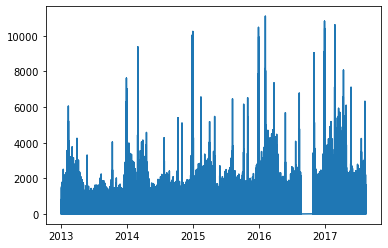

In [11]:
plt.plot('date', 'sales', data = train[train['store_nbr'] == 25])
plt.show();

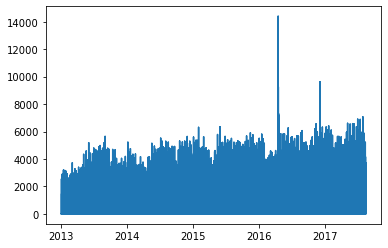

In [12]:
plt.plot('date', 'sales', data = train[train['store_nbr'] == 27])
plt.show();